# Sentiment Classification With Multilayer Perceptrons and SVMs

Here, we are going to take a shot at sentiment classification, using both a multilayer perceptron and an SVM. Our question here is if these models will be able to capture the features of a sentence that define if it is "positive" or "negative", A.K.A. its sentiment. 

For this project, I'm going to be using [yelp](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) reviews from the UCI Machine Learning Repository. 

In [388]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support

Lets start by downloading some NLTK libraries to help us process the raw review data. 

In [12]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dylan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dylan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# The Yelp Dataset

In [276]:
yelp_dataset = pd.read_csv("yelp_labelled.txt", sep = '\t', header = None).sample(frac = 1)
yelp_dataset.columns = ['Sentence', 'Sentiment']

Lets check out a few sentences, and their sentiment, from the shuffled dataset.

In [277]:
yelp_dataset.head()

,Sentence,Sentiment
935,This place lacked style!!,0
379,"The staff are now not as friendly, the wait ti...",0
743,"When I opened the sandwich, I was impressed, b...",0
506,Overall I wasn't very impressed with Noca.,0
325,The black eyed peas and sweet potatoes... UNREAL!,1


In order to convert our text to numerical values, we're going to be using a TF-IDF vectorizer. This vectorizer is going to encode words based on how frequently they appear, while at the same time penalizing words for showing up very often. This is done as very common words may prove to be useless to the encoding of a corpus of data. 

In [394]:
vectorizer = TfidfVectorizer(analyzer = 'word',
                             max_features = 2000,
                             tokenizer = word_tokenize,
                             stop_words = stopwords.words('english'))

In [395]:
yelp_vecs_X = vectorizer.fit_transform(yelp_dataset['Sentence']).toarray()
yelp_vecs_Y = yelp_dataset["Sentiment"]

c:\users\dylan\appdata\local\programs\python\python36\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [396]:
from sklearn.neural_network import MLPClassifier

In [397]:
num_training = int(0.8*len(yelp_vecs_X))
yelp_vecs_X_train = yelp_vecs_X[:num_training,:]
yelp_vecs_X_test = yelp_vecs_X[num_training:, :]
yelp_vecs_Y_train = yelp_vecs_Y[:num_training]
yelp_vecs_Y_test = yelp_vecs_Y[num_training:]

Let's try to use a multilayer perceptron to classify sentences by sentiment. 

## Activation Functions

There is a multitude of different activation functions we could use in our perceptron model. Every function has its positives and negatives, so we will choose the optimal function by including them in our hyper-parameter grid search. Below is a demonstration of the different activation functions we will be iterating over. Notice the difference in the y-axis between each function, this is important to how the model will perform in the classification stage. 

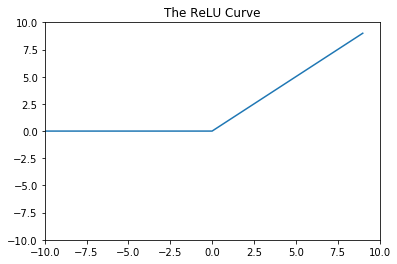

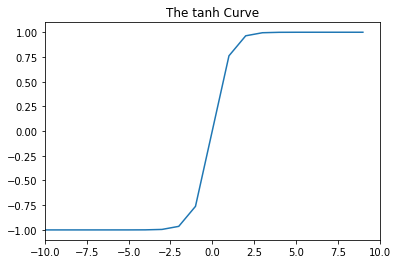

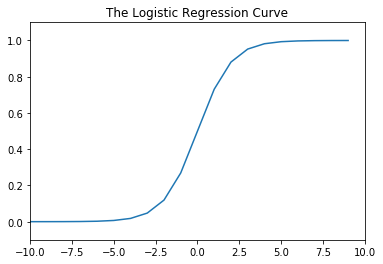

In [320]:
def ReLU(x):
    return max(0, x)

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

def logreg(x):
    return 1 / (1 + np.exp(-x))

ReLU_vals = []
tanh_vals = []
logreg_vals = []
x = list(range(-10, 10))
for val in x:
    ReLU_vals.append(ReLU(val))
    tanh_vals.append(tanh(val))
    logreg_vals.append(logreg(val))
    

plt.plot(x,ReLU_vals)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.title("The ReLU Curve")
plt.show()

plt.plot(x,tanh_vals)
plt.xlim(-10,10)
plt.ylim(-1.10,1.10)
plt.title("The tanh Curve")
plt.show()

plt.plot(x,logreg_vals)
plt.xlim(-10,10)
plt.ylim(-.10,1.10)
plt.title("The Logistic Regression Curve")
plt.show()

## Predicting Sentiment

Let's try to find the optimal set of hyperparameters that we can pick for our perceptron model. SKlearn has a convenient library for iterating over hyperparameters, where each combination of hyperparameters is cross-validated in order to find the best score. 

In [39]:
from sklearn.model_selection import GridSearchCV

Let's iterate over a few different parameters. First, we can go through each activation function that we mentioned earlier. 

There are many other hyperparameters that we could iterate over, but for now we will focus on the different activation functions, as well as different architectures of hidden-layers for our perceptron.



Sklearn lets you conveniently define the architecture of your neural net using tuple notation. To be specific, the *ith* entry in the tuple is the amount of **nodes** in the *ith* **hidden layer**. For example, a model with two hidden layers with 100 nodes each would be written as (100,100). As you can see below, I have chosen an arbitrary set of three hidden-layer architectures to try in our MLP model. 

For the **solver**, we will be using stochastic gradient descent. The 'solver' parameter is essentially the method that the model will use to perform an **update** to the weights at each iteration. 

Finally, **max_iter** is the amount of iterations that the model will perform before returning the final weights. The beauty of this sklearn package is that, if the model **converges** BEFORE the maximum iteration is met, then the model will return at that point. To be safe though, I'm setting a maximum iteration of 2000, so that the model has ample time to converge.

In [304]:
param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
             'hidden_layer_sizes': [(100, 50), (50, 100), (100,100)]}

MLP_model = MLPClassifier(solver = 'sgd',
                          max_iter = 2000)

MLP_clf = GridSearchCV(MLP_model, param_grid, cv = 3)

In [305]:
MLP_clf.fit(yelp_vecs_X_train, yelp_vecs_Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [(100, 50), (50, 100), (100, 100)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Now let's see the model's best-performing hyperparameters. 

In [306]:
print(MLP_clf.best_params_)

{'activation': 'identity', 'hidden_layer_sizes': (100, 100)}


Surprisingly, the 3-fold cross validated grid search has told us that the best-performing activation function is the identity function, which tells us that our data may not need the non-linear mapping provided by the ReLU, tanh, or other functions shown above.

Now, let's train our model with these hyperparameters and see the results.

In [401]:
best_MLP_model = MLPClassifier(solver = 'sgd',
                               activation = 'identity',
                               hidden_layer_sizes =(100,100),
                               max_iter = 2000)
best_MLP_model.fit(yelp_vecs_X_train, yelp_vecs_Y_train)

MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [402]:
yelp_vecs_pred_train_Y = best_MLP_model.predict(yelp_vecs_X_train)
yelp_vecs_pred_test_Y = best_MLP_model.predict(yelp_vecs_X_test)
print(classification_report(yelp_vecs_Y_train, yelp_vecs_pred_train_Y))
print(classification_report(yelp_vecs_Y_test, yelp_vecs_pred_test_Y))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       397
           1       1.00      1.00      1.00       403

   micro avg       1.00      1.00      1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       103
           1       0.77      0.77      0.77        97

   micro avg       0.78      0.78      0.78       200
   macro avg       0.78      0.78      0.78       200
weighted avg       0.78      0.78      0.78       200



The performance output tells us that we're seeing around 78% accuracy across precision and recall in our test scores. This isn't too bad. 

# SVM

In [51]:
from sklearn.svm import SVC

Let's see how an SVM performs in sentiment classification over our previous multilayer perceptron. 


To illustrate what an SVM is doing, lets start with generating a theoretical distribution.

In [372]:
from sklearn.datasets import make_circles

The graph below represents a distribution of two different categories. Each color represents a different category. As we can see, our SVM will have to draw the decision boundary in a third circle between the purple and yellow circles. 

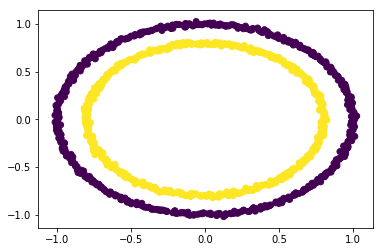

In [380]:
X,Y = make_circles(n_samples = 1000, noise = 0.01)

        
plt.scatter(X[:,0], X[:,1], c = Y)
plt.show()

In [373]:
X_vals = X[:,0]
Y_vals = X[:,1]

X_train, X_test = X[:800], X[800:]
Y_train, Y_test = Y[:800], Y[800:]

Let's formulate a classifier for this distribution. Finding a good SVM to model your data can sometimes amount to finding a good combination of your **gamma** and **C** hyperparameters. 

After playing around with a few different values of C and gamma (large C/small gamma, small C/large gamma, etc), it looks like our defining factor on the strength of our model is the size of gamma. Let's look at what happens when gamma is too small:

In [358]:
toy_model = SVC(C = 0.01, gamma = 10e-2, kernel = 'poly', degree = 4)
toy_model.fit(X_train, Y_train)
Y_train_pred = toy_model.predict(X_train)
Y_test_pred = toy_model.predict(X_test)
print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67       406
           1       0.00      0.00      0.00       394

   micro avg       0.51      0.51      0.51       800
   macro avg       0.25      0.50      0.34       800
weighted avg       0.26      0.51      0.34       800

              precision    recall  f1-score   support

           0       0.47      1.00      0.64        94
           1       0.00      0.00      0.00       106

   micro avg       0.47      0.47      0.47       200
   macro avg       0.23      0.50      0.32       200
weighted avg       0.22      0.47      0.30       200



c:\users\dylan\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


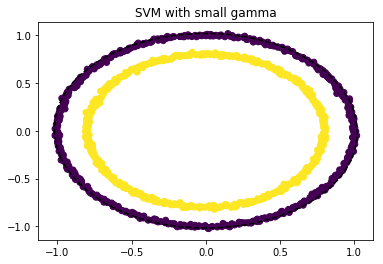

In [359]:
#print(toy_model.support_vectors_)
plt.scatter(X[:,0], X[:,1], c = Y)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = toy_model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1],
           linestyles=['--', '-', '--'])
plt.title("SVM with small gamma")
plt.show()

In the above case, it looks like the decision boundary exists outside of the two rings. In fact, the decision boundary is nowhere to be seen in the above figure. Thus, it is completely missing the fact that there are two different categories to classify. 

Now let's try a large gamma. 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       1.00      1.00      1.00       394

   micro avg       1.00      1.00      1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        94
           1       1.00      1.00      1.00       106

   micro avg       1.00      1.00      1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



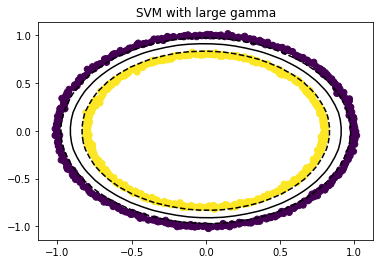

In [362]:
toy_model = SVC(C = 0.01, gamma = 100, kernel = 'poly', degree = 4)
toy_model.fit(X_train, Y_train)
Y_train_pred = toy_model.predict(X_train)
Y_test_pred = toy_model.predict(X_test)
print(classification_report(Y_train, Y_train_pred))
print(classification_report(Y_test, Y_test_pred))

#print(toy_model.support_vectors_)
plt.scatter(X[:,0], X[:,1], c = Y)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = toy_model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1],
           linestyles=['--', '-', '--'])
plt.title("SVM with large gamma")
plt.show()

As you can see, our theoretical model is reaching perfect accuracy (not something you would likely see in the real world). With a large gamma, the model was able to place the positive and negative hyperplanes (the dotted lines) right on the edges of each ring, with the decision boundary lying in the middle. It's difficult to see, but the positive hyperplane exists at the edge of the purple ring closest to the decision boundary.  

Now let's apply the SVM to sentiment classification. First, we're going to perform another grid search over some different hyperparameters in order to achieve the best validation score. As you can see, we're first iterating over C. Then we move on to the kernel. We will be checking the performance of the linear kernel, the radial basis function kernel, and the polynomial kernel here. Finally, We're iterating over the degree, which only applies when dealing with the polynomial kernel. 

Unfortunately, iterating over different values of gamma proves to be very computationally expensive when grid-searching over different parameters. Instead, we will set the gamma to scale. We will iterate over gamma values in a separate grid-search below. For now, the gamma will be defined as 

$$\frac{1}{n \cdot var(X)}$$

where $n$ refers to the number of features in our dataset. 

In [341]:
param_grid = {'C': [0.01, 0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly'],
              'degree': [2,3,4]}

svm_model = SVC(gamma = 'scale')

SVM_clf = GridSearchCV(svm_model, param_grid, cv = 3)

SVM_clf.fit(yelp_vecs_X_train, yelp_vecs_Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [342]:
print(SVM_clf.best_params_)

{'C': 1, 'degree': 2, 'kernel': 'linear'}


As we can see above, our grid-search has determined that a linear kernel with a C of 1 is the optimal set of parameters chosen from our list above. Since the optimal kernel is linear, we can ignore the degree parameter (of which only applies to polynomial kernels). 

Now, lets iterate over different **gammas** to be used with our other optimal hyperparameters:

In [376]:
gamma_list = {'gamma': [10e-3, 10e-2, 10e-1, 
              10, 10e1, 10e2, 10e3]}

svm_model = SVC(C = 1, kernel = 'linear')

gamma_grid_search = GridSearchCV(svm_model, gamma_list, cv = 3)

gamma_grid_search.fit(yelp_vecs_X_train, yelp_vecs_Y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': [0.01, 0.1, 1.0, 10, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

3-fold cross-validation tells us that the best gamma for our model is 0.01. 

In [377]:
print(gamma_grid_search.best_params_)

{'gamma': 0.01}


In [400]:
best_svm = SVC(C = 1, gamma = 0.01, kernel = 'linear')
best_svm.fit(yelp_vecs_X_train, yelp_vecs_Y_train)
yelp_vecs_pred_train_Y = best_svm.predict(yelp_vecs_X_train)
yelp_vecs_pred_test_Y = best_svm.predict(yelp_vecs_X_test)
print(classification_report(yelp_vecs_Y_train, yelp_vecs_pred_train_Y))
print(classification_report(yelp_vecs_Y_test, yelp_vecs_pred_test_Y))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       397
           1       0.98      0.96      0.97       403

   micro avg       0.97      0.97      0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       103
           1       0.78      0.78      0.78        97

   micro avg       0.79      0.79      0.79       200
   macro avg       0.79      0.79      0.79       200
weighted avg       0.79      0.79      0.79       200



Above is the final accuracy report for our model. These slightly better results compared to the performance of the multilayer perceptron that was trained above. 